# Imports

In [1]:
import random
import math
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import special

import torch 
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms
from torchsummary import summary

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = torch.device('cuda') 
print('device : ', device)
print('num gpu : ', torch.cuda.device_count())

device :  cuda
num gpu :  4


# Generate Data

In [229]:
SEED = 42

In [179]:
class StepDataset(data.Dataset):
    
    def __init__(self, upper=5, lower=-3, length=100, error_range=0.1, center=1, ymax=1., x_var=None, y_var=None, model_mean=None, seed=1234):
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        
        self.upper = upper
        self.lower = lower
        self.length = length
        self.error_range = error_range
        self.y_var = y_var
        if self.y_var != None:
            self.noise = np.array([np.random.normal(center,self.y_var) for i in range(self.length)]).reshape(-1,1).astype(np.float32)
        else:
            self.noise = np.array([2 * self.error_range * np. random.rand() - self.error_range for i in range(self.length)]).reshape(-1,1).astype(np.float32)
            self.y_var = (2*self.error_range)**2/12
        
        if x_var != None:
            self.input = np.array([[(self.upper - self.lower) * np. random.rand() + self.lower, x_var] for i in range(self.length)]).astype(np.float32)
            self.output = np.array([[x.item()*ymax,self.y_var] for x in (self.input[:,0]>center)]).astype(np.float32)
            self.output[:,0] += self.noise.reshape(-1)
        else:    
            self.input = np.array([(self.upper - self.lower) * np. random.rand() + self.lower for i in range(self.length)]).reshape(-1,1).astype(np.float32)
            self.output = (ymax * (self.input > center) + self.noise).astype(np.float32)
            if model_mean!=None:
                pred = model_mean(torch.tensor(self.input)).to("cpu")
                self.output = torch.abs(torch.tensor(self.output) - pred)


    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        x = self.input[index]
        y = self.output[index]
        
        return x, y

In [188]:
dataset = StepDataset(ymax=4.)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=100,shuffle=True)
x, y = next(iter(dataloader))
x.shape

torch.Size([100, 1])

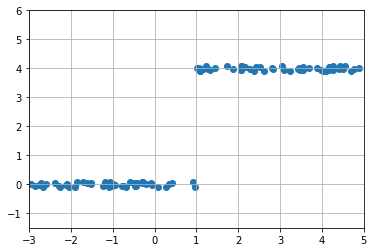

In [198]:
# dataset = StepDataset(ymax=4.)
dataset = StepDataset(5,-3,100,0.1,center=1,ymax=4.,seed=SEED)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=100,shuffle=True)
x, y = next(iter(dataloader))
x = x[:,0]
y = y[:,0]


plt.scatter(x, y)
plt.xlim(-3, 5)
plt.ylim(-1.5, 6.)
plt.grid()
plt.show()

# Basic Regression Model

## Modeling

In [7]:
class BasicRegressor(nn.Module):
    
    def __init__(self):
        super(BasicRegressor, self).__init__()
        self.layer1 = nn.Linear(1, 200)
        self.layer2 = nn.Linear(200, 200)
        self.last = nn.Linear(200, 1)
        self.dropout = nn.Dropout(p=0.01)
        
    def forward(self, x):
        out = self.layer1(x)
        out = F.relu(out)
        out = self.dropout(out)
        out = self.layer2(out)
        out = F.relu(out)
        out = self.dropout(out)
        out = self.last(out)
        
        return out

In [8]:
net = BasicRegressor().to(device)
print(net)
summary(net,(1,))

BasicRegressor(
  (layer1): Linear(in_features=1, out_features=200, bias=True)
  (layer2): Linear(in_features=200, out_features=200, bias=True)
  (last): Linear(in_features=200, out_features=1, bias=True)
  (dropout): Dropout(p=0.01, inplace=False)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 200]             400
           Dropout-2                  [-1, 200]               0
            Linear-3                  [-1, 200]          40,200
           Dropout-4                  [-1, 200]               0
            Linear-5                    [-1, 1]             201
Total params: 40,801
Trainable params: 40,801
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.16
Estimated Total Size (MB): 0.16
--------------------------------------------------

In [9]:
net = BasicRegressor()
net(torch.tensor([[0.]]))

tensor([[-0.1086]], grad_fn=<AddmmBackward>)

## Train

### Mean Model

In [39]:
def train_mean(model, dataloader, num_epochs, lr=2e-3):   
    model = nn.DataParallel(model)
    model.to(device)
    model.train()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    for epoch in range(num_epochs):      
        t_epoch_start = time.time()
        epoch_loss = 0.0
        
        print('-------------')
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')
        
        for data in dataloader:       
            batch_size = len(data[0])
            x = data[0].to(device)
            y = data[1].to(device)
            out = model(x)
            
            loss = criterion(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Loss:{:.4f} '.format(epoch, epoch_loss/batch_size))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        
    model.eval()        
    return model

In [226]:
dataset = StepDataset(5,-3,100,error_range=0.1,center=1,ymax=4.,seed=SEED)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=64,shuffle=True)

model_mean = BasicRegressor()
model_mean = train_mean(model_mean, dataloader,300,lr=5e-3)

-------------
Epoch 1/300
-------------
-------------
epoch 0 || Loss:0.2295 
timer:  0.0627 sec.
-------------
Epoch 2/300
-------------
-------------
epoch 1 || Loss:0.1501 
timer:  0.0133 sec.
-------------
Epoch 3/300
-------------
-------------
epoch 2 || Loss:0.0795 
timer:  0.0314 sec.
-------------
Epoch 4/300
-------------
-------------
epoch 3 || Loss:0.0668 
timer:  0.0167 sec.
-------------
Epoch 5/300
-------------
-------------
epoch 4 || Loss:0.0725 
timer:  0.0204 sec.
-------------
Epoch 6/300
-------------
-------------
epoch 5 || Loss:0.0532 
timer:  0.0187 sec.
-------------
Epoch 7/300
-------------
-------------
epoch 6 || Loss:0.0431 
timer:  0.0201 sec.
-------------
Epoch 8/300
-------------
-------------
epoch 7 || Loss:0.0458 
timer:  0.0238 sec.
-------------
Epoch 9/300
-------------
-------------
epoch 8 || Loss:0.0373 
timer:  0.0287 sec.
-------------
Epoch 10/300
-------------
-------------
epoch 9 || Loss:0.0311 
timer:  0.0153 sec.
-------------
Epoch

-------------
epoch 87 || Loss:0.0051 
timer:  0.0135 sec.
-------------
Epoch 89/300
-------------
-------------
epoch 88 || Loss:0.0055 
timer:  0.0122 sec.
-------------
Epoch 90/300
-------------
-------------
epoch 89 || Loss:0.0054 
timer:  0.0133 sec.
-------------
Epoch 91/300
-------------
-------------
epoch 90 || Loss:0.0058 
timer:  0.0159 sec.
-------------
Epoch 92/300
-------------
-------------
epoch 91 || Loss:0.0067 
timer:  0.0223 sec.
-------------
Epoch 93/300
-------------
-------------
epoch 92 || Loss:0.0077 
timer:  0.0168 sec.
-------------
Epoch 94/300
-------------
-------------
epoch 93 || Loss:0.0061 
timer:  0.0151 sec.
-------------
Epoch 95/300
-------------
-------------
epoch 94 || Loss:0.0064 
timer:  0.0134 sec.
-------------
Epoch 96/300
-------------
-------------
epoch 95 || Loss:0.0046 
timer:  0.0199 sec.
-------------
Epoch 97/300
-------------
-------------
epoch 96 || Loss:0.0045 
timer:  0.0105 sec.
-------------
Epoch 98/300
-------------


-------------
epoch 180 || Loss:0.0033 
timer:  0.0143 sec.
-------------
Epoch 182/300
-------------
-------------
epoch 181 || Loss:0.0026 
timer:  0.0263 sec.
-------------
Epoch 183/300
-------------
-------------
epoch 182 || Loss:0.0027 
timer:  0.0161 sec.
-------------
Epoch 184/300
-------------
-------------
epoch 183 || Loss:0.0031 
timer:  0.0175 sec.
-------------
Epoch 185/300
-------------
-------------
epoch 184 || Loss:0.0032 
timer:  0.0164 sec.
-------------
Epoch 186/300
-------------
-------------
epoch 185 || Loss:0.0025 
timer:  0.0140 sec.
-------------
Epoch 187/300
-------------
-------------
epoch 186 || Loss:0.0037 
timer:  0.0121 sec.
-------------
Epoch 188/300
-------------
-------------
epoch 187 || Loss:0.0032 
timer:  0.0135 sec.
-------------
Epoch 189/300
-------------
-------------
epoch 188 || Loss:0.0042 
timer:  0.0158 sec.
-------------
Epoch 190/300
-------------
-------------
epoch 189 || Loss:0.0024 
timer:  0.0175 sec.
-------------
Epoch 19

-------------
epoch 271 || Loss:0.0040 
timer:  0.0180 sec.
-------------
Epoch 273/300
-------------
-------------
epoch 272 || Loss:0.0044 
timer:  0.0134 sec.
-------------
Epoch 274/300
-------------
-------------
epoch 273 || Loss:0.0034 
timer:  0.0147 sec.
-------------
Epoch 275/300
-------------
-------------
epoch 274 || Loss:0.0026 
timer:  0.0194 sec.
-------------
Epoch 276/300
-------------
-------------
epoch 275 || Loss:0.0027 
timer:  0.0180 sec.
-------------
Epoch 277/300
-------------
-------------
epoch 276 || Loss:0.0024 
timer:  0.0160 sec.
-------------
Epoch 278/300
-------------
-------------
epoch 277 || Loss:0.0042 
timer:  0.0312 sec.
-------------
Epoch 279/300
-------------
-------------
epoch 278 || Loss:0.0022 
timer:  0.0172 sec.
-------------
Epoch 280/300
-------------
-------------
epoch 279 || Loss:0.0026 
timer:  0.0127 sec.
-------------
Epoch 281/300
-------------
-------------
epoch 280 || Loss:0.0030 
timer:  0.0120 sec.
-------------
Epoch 28

### Error Model

In [12]:
# dataset = StepDataset(ymax=4., model_mean=model_mean)
# dataloader = torch.utils.data.DataLoader(dataset,batch_size=100,shuffle=True)
# x, y = next(iter(dataloader))
# y

In [13]:
class CustomLoss(nn.Module):
    
    def __init__(self, beta=0.1):
        super(CustomLoss, self).__init__()
        self.beta = beta
        
    def forward(self, x, y):
        dist = torch.sum(
            torch.pow((y - x).clamp(min=0.),2) + self.beta*torch.pow((y - x).clamp(max=0.),2)
            )
        loss = dist/(x.shape[0]*x.shape[1])
        return loss

In [40]:
def train_error(model, dataloader, num_epochs, lr=2e-3):   
    model = nn.DataParallel(model)
    model.to(device)
    model.train()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = CustomLoss(beta=0.1)
    
    for epoch in range(num_epochs):      
        t_epoch_start = time.time()
        epoch_loss = 0.0
        
        print('-------------')
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')
        
        for data in dataloader:       
            batch_size = len(data[0])
            x = data[0].to(device)
            y = data[1].to(device)
            out = model(x)
            
            loss = criterion(out, y)
            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()
            
            epoch_loss += loss.item()
            
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Loss:{:.4f} '.format(epoch, epoch_loss/batch_size))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        
    model.eval()        
    return model

In [227]:
dataset = StepDataset(5,-3,100,error_range=0.1,center=1,ymax=4.,model_mean=model_mean,seed=SEED)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=64,shuffle=True)

model_error = BasicRegressor()

model_error = train_error(model_error, dataloader, 600, lr=5e-3)

-------------
Epoch 1/600
-------------
-------------
epoch 0 || Loss:0.0889 
timer:  0.0213 sec.
-------------
Epoch 2/600
-------------
-------------
epoch 1 || Loss:0.0063 
timer:  0.0381 sec.
-------------
Epoch 3/600
-------------
-------------
epoch 2 || Loss:0.0245 
timer:  0.0260 sec.
-------------
Epoch 4/600
-------------
-------------
epoch 3 || Loss:0.0259 
timer:  0.0253 sec.
-------------
Epoch 5/600
-------------
-------------
epoch 4 || Loss:0.0155 
timer:  0.0224 sec.
-------------
Epoch 6/600
-------------
-------------
epoch 5 || Loss:0.0063 
timer:  0.0217 sec.
-------------
Epoch 7/600
-------------
-------------
epoch 6 || Loss:0.0032 
timer:  0.0198 sec.
-------------
Epoch 8/600
-------------
-------------
epoch 7 || Loss:0.0025 
timer:  0.0275 sec.
-------------
Epoch 9/600
-------------
-------------
epoch 8 || Loss:0.0027 
timer:  0.0202 sec.
-------------
Epoch 10/600
-------------
-------------
epoch 9 || Loss:0.0013 
timer:  0.0201 sec.
-------------
Epoch

-------------
epoch 89 || Loss:0.0002 
timer:  0.0278 sec.
-------------
Epoch 91/600
-------------
-------------
epoch 90 || Loss:0.0001 
timer:  0.0257 sec.
-------------
Epoch 92/600
-------------
-------------
epoch 91 || Loss:0.0002 
timer:  0.0256 sec.
-------------
Epoch 93/600
-------------
-------------
epoch 92 || Loss:0.0002 
timer:  0.0454 sec.
-------------
Epoch 94/600
-------------
-------------
epoch 93 || Loss:0.0002 
timer:  0.0252 sec.
-------------
Epoch 95/600
-------------
-------------
epoch 94 || Loss:0.0002 
timer:  0.0253 sec.
-------------
Epoch 96/600
-------------
-------------
epoch 95 || Loss:0.0002 
timer:  0.0246 sec.
-------------
Epoch 97/600
-------------
-------------
epoch 96 || Loss:0.0002 
timer:  0.0338 sec.
-------------
Epoch 98/600
-------------
-------------
epoch 97 || Loss:0.0001 
timer:  0.0295 sec.
-------------
Epoch 99/600
-------------
-------------
epoch 98 || Loss:0.0002 
timer:  0.0280 sec.
-------------
Epoch 100/600
-------------

-------------
epoch 172 || Loss:0.0001 
timer:  0.0231 sec.
-------------
Epoch 174/600
-------------
-------------
epoch 173 || Loss:0.0001 
timer:  0.0232 sec.
-------------
Epoch 175/600
-------------
-------------
epoch 174 || Loss:0.0002 
timer:  0.0326 sec.
-------------
Epoch 176/600
-------------
-------------
epoch 175 || Loss:0.0001 
timer:  0.0247 sec.
-------------
Epoch 177/600
-------------
-------------
epoch 176 || Loss:0.0001 
timer:  0.0213 sec.
-------------
Epoch 178/600
-------------
-------------
epoch 177 || Loss:0.0001 
timer:  0.0233 sec.
-------------
Epoch 179/600
-------------
-------------
epoch 178 || Loss:0.0001 
timer:  0.0227 sec.
-------------
Epoch 180/600
-------------
-------------
epoch 179 || Loss:0.0001 
timer:  0.0215 sec.
-------------
Epoch 181/600
-------------
-------------
epoch 180 || Loss:0.0001 
timer:  0.0221 sec.
-------------
Epoch 182/600
-------------
-------------
epoch 181 || Loss:0.0001 
timer:  0.0322 sec.
-------------
Epoch 18

-------------
epoch 258 || Loss:0.0001 
timer:  0.0226 sec.
-------------
Epoch 260/600
-------------
-------------
epoch 259 || Loss:0.0001 
timer:  0.0255 sec.
-------------
Epoch 261/600
-------------
-------------
epoch 260 || Loss:0.0001 
timer:  0.0196 sec.
-------------
Epoch 262/600
-------------
-------------
epoch 261 || Loss:0.0001 
timer:  0.0170 sec.
-------------
Epoch 263/600
-------------
-------------
epoch 262 || Loss:0.0001 
timer:  0.0164 sec.
-------------
Epoch 264/600
-------------
-------------
epoch 263 || Loss:0.0001 
timer:  0.0163 sec.
-------------
Epoch 265/600
-------------
-------------
epoch 264 || Loss:0.0001 
timer:  0.0157 sec.
-------------
Epoch 266/600
-------------
-------------
epoch 265 || Loss:0.0001 
timer:  0.0183 sec.
-------------
Epoch 267/600
-------------
-------------
epoch 266 || Loss:0.0002 
timer:  0.0233 sec.
-------------
Epoch 268/600
-------------
-------------
epoch 267 || Loss:0.0001 
timer:  0.0245 sec.
-------------
Epoch 26

-------------
epoch 339 || Loss:0.0001 
timer:  0.0200 sec.
-------------
Epoch 341/600
-------------
-------------
epoch 340 || Loss:0.0000 
timer:  0.0196 sec.
-------------
Epoch 342/600
-------------
-------------
epoch 341 || Loss:0.0000 
timer:  0.0218 sec.
-------------
Epoch 343/600
-------------
-------------
epoch 342 || Loss:0.0001 
timer:  0.0197 sec.
-------------
Epoch 344/600
-------------
-------------
epoch 343 || Loss:0.0000 
timer:  0.0221 sec.
-------------
Epoch 345/600
-------------
-------------
epoch 344 || Loss:0.0000 
timer:  0.0227 sec.
-------------
Epoch 346/600
-------------
-------------
epoch 345 || Loss:0.0001 
timer:  0.0232 sec.
-------------
Epoch 347/600
-------------
-------------
epoch 346 || Loss:0.0001 
timer:  0.0225 sec.
-------------
Epoch 348/600
-------------
-------------
epoch 347 || Loss:0.0001 
timer:  0.0213 sec.
-------------
Epoch 349/600
-------------
-------------
epoch 348 || Loss:0.0003 
timer:  0.0454 sec.
-------------
Epoch 35

-------------
epoch 426 || Loss:0.0000 
timer:  0.0266 sec.
-------------
Epoch 428/600
-------------
-------------
epoch 427 || Loss:0.0000 
timer:  0.0202 sec.
-------------
Epoch 429/600
-------------
-------------
epoch 428 || Loss:0.0000 
timer:  0.0161 sec.
-------------
Epoch 430/600
-------------
-------------
epoch 429 || Loss:0.0000 
timer:  0.0189 sec.
-------------
Epoch 431/600
-------------
-------------
epoch 430 || Loss:0.0000 
timer:  0.0217 sec.
-------------
Epoch 432/600
-------------
-------------
epoch 431 || Loss:0.0000 
timer:  0.0255 sec.
-------------
Epoch 433/600
-------------
-------------
epoch 432 || Loss:0.0000 
timer:  0.0264 sec.
-------------
Epoch 434/600
-------------
-------------
epoch 433 || Loss:0.0001 
timer:  0.0244 sec.
-------------
Epoch 435/600
-------------
-------------
epoch 434 || Loss:0.0000 
timer:  0.0244 sec.
-------------
Epoch 436/600
-------------
-------------
epoch 435 || Loss:0.0001 
timer:  0.0354 sec.
-------------
Epoch 43

-------------
epoch 514 || Loss:0.0000 
timer:  0.0209 sec.
-------------
Epoch 516/600
-------------
-------------
epoch 515 || Loss:0.0000 
timer:  0.0148 sec.
-------------
Epoch 517/600
-------------
-------------
epoch 516 || Loss:0.0000 
timer:  0.0188 sec.
-------------
Epoch 518/600
-------------
-------------
epoch 517 || Loss:0.0000 
timer:  0.0202 sec.
-------------
Epoch 519/600
-------------
-------------
epoch 518 || Loss:0.0000 
timer:  0.0192 sec.
-------------
Epoch 520/600
-------------
-------------
epoch 519 || Loss:0.0000 
timer:  0.0224 sec.
-------------
Epoch 521/600
-------------
-------------
epoch 520 || Loss:0.0000 
timer:  0.0199 sec.
-------------
Epoch 522/600
-------------
-------------
epoch 521 || Loss:0.0000 
timer:  0.0230 sec.
-------------
Epoch 523/600
-------------
-------------
epoch 522 || Loss:0.0000 
timer:  0.0225 sec.
-------------
Epoch 524/600
-------------
-------------
epoch 523 || Loss:0.0000 
timer:  0.0209 sec.
-------------
Epoch 52

## Validation

/home/yashima/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  


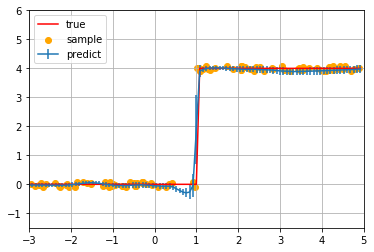

In [228]:
length = 100
start = -3
end = 5
waith = end - start
val_x = torch.tensor([[i] for i in np.arange(start,end,waith/length)])
val_y = (val_x>1)*4
pred_y = model_mean(val_x).detach().cpu()
pred_std = model_error(val_x).detach().cpu()


fig = plt.figure()
ax = fig.add_subplot(1,1,1)
# ax.plot(val_x, pred_y,  label="predict")
ax.errorbar(val_x, pred_y, pred_std, label="predict")
ax.plot(val_x, val_y, label="true",c="red")


dataset = StepDataset(5,-3,100,0.1,center=1,ymax=4.,seed=SEED)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=100,shuffle=True)
x, y = next(iter(dataloader))
x = x[:,0]
y = y[:,0]
ax.scatter(x, y,c="orange",label="sample")


ax.grid()
ax.legend(loc='upper left')
plt.xlim(-3, 5)
plt.ylim(-1.5, 6)
fig.show()

# Stochastic Reression Model

## Modeling

### Modified ReLU

In [17]:
def ReLUGauss(mu_in, var_in, epsilon=1.0e-6, cut_sd=4.0):
    mu_out = torch.zeros(mu_in.shape[0], mu_in.shape[1])
    var_out = torch.zeros(var_in.shape[0], var_in.shape[1])
    mu = mu_in
    var = var_in
    sigma = torch.sqrt(var+1e-16)

    if (var < 0).any().item(): raise Exception(f"ERROR in ReLUGauss: 'var_in' should be all positive value, but it has negative value.")
    idx_SmallSigma = (sigma < epsilon)
    if cut_sd != None:
        idx_LargeMu = (mu > cut_sd*sigma)
        idx_SmallMU = (mu < -cut_sd*sigma)

    sqrt2 = math.sqrt(2.0)
    sqrt2pi = math.sqrt(2.0*math.pi)    
    z = mu / (sqrt2*sigma+1e-16)
    E = torch.erf(z)
    X = torch.exp(-z*z)
    mu_out = sigma/sqrt2pi*X + mu/2.0*(1.0+E)
    var_out = (1.0+E)/4.0*(mu*mu*(1.0-E)+2.0*var) - sigma*X/sqrt2pi*(sigma*X/sqrt2pi+mu*E)
    
    idx_SmallVarOut = (var_out<0.0)*(var_out>-epsilon)
    isError = ((var_out<0.0)*(var_out<=-epsilon)).any().item()
    if isError:
        msg= f'ERROR in ReLUGauss: (mu: {mu}\n, sigma: {sigma}\n, mu_out: {mu_out}\n, var_out: {var_out}\n)'
        print(msg)
        raise Exception(msg)


    mu_out = mu_out*~idx_SmallSigma + idx_SmallSigma*torch.relu(mu)
    var_out *= ~idx_SmallSigma
    if cut_sd != None:
        mu_out = mu_out*~(idx_LargeMu*~idx_SmallSigma) + (idx_LargeMu*~idx_SmallSigma)*mu
        var_out = var_out*~(idx_LargeMu*~idx_SmallSigma) + (idx_LargeMu*~idx_SmallSigma)*var
        mu_out = mu_out*~(idx_SmallMU*~(idx_LargeMu|idx_SmallSigma))
        var_out = var_out*~(idx_SmallMU*~(idx_LargeMu|idx_SmallSigma))
        var_out = var_out*~(idx_SmallVarOut*~((idx_LargeMu|idx_SmallSigma)|idx_SmallMU))
    else:
        var_out = var_out*~(idx_SmallVarOut*~idx_SmallSigma)
            
    var_out = torch.diag_embed(var_out)
    
    return mu_out, var_out

/home/yashima/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  if sys.path[0] == '':


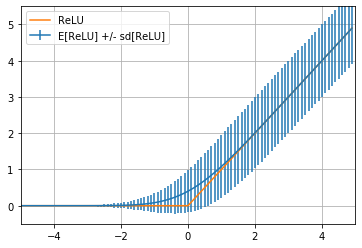

In [18]:
length = 100
start = -5
end = 5
waith = end - start
x = torch.arange(start, end, waith/length).view(-1, 1)
in_var = torch.ones(length, 1)
y, out_var = ReLUGauss(x, in_var)
out_var = out_var.reshape(-1, 1)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.errorbar(x, y, torch.sqrt(out_var), label="E[ReLU] +/- sd[ReLU]")
ax.plot(x, torch.relu(x), label="ReLU")
ax.grid()
ax.legend(loc='upper left')
plt.xlim(start, end)
plt.ylim(-0.5, end+0.5)
fig.show()

Fig. 2. Expectation of ReLU.

### Custom DropOut

In [19]:
class CustomDropout(nn.Module):
    
    __constants__ = ['p', 'inplace']

    def __init__(self, p=0.5, inplace=False):
        super(CustomDropout, self).__init__()
        if p < 0 or p > 1:
            raise ValueError("dropout probability has to be between 0 and 1, "
                             "but got {}".format(p))
        self.p = p
        self.inplace = inplace
        self.flag = torch.zeros(1,1)
    
    def forward(self, input):
        mu_in = input[0]
        var_in = input[1]    
        self.flag = F.dropout(torch.ones(mu_in.shape[0], mu_in.shape[1]), self.p, self.training, self.inplace)
        self.flag = self.flag.to(device)
        try:           
            mu_out = mu_in*self.flag
            var_out = var_in*(torch.diag_embed(self.flag))
        except:     
            self.flag = self.flag.to("cpu")
            mu_out = mu_in*self.flag
            var_out = var_in*(torch.diag_embed(self.flag))
        
        return mu_out, var_out
    
    def extra_repr(self):
        return 'p={}, inplace={}'.format(self.p, self.inplace)
    
    def to(self, *args, **kwargs):
        self.b = self.flag.to(*args, **kwargs) 
        return self

### Modeling

In [20]:
def ModifyInput(input):
    if input.dim() == 2:
        mu = input[:, 0].unsqueeze(-1)
        var = input[:, 1].unsqueeze(-1).unsqueeze(-1)
    else:
        raise Exception("Input shape should be (BATCH x 2).")
    return mu, var

def ModifyOutput(input):
    mu = input[0]
    var = input[1]
    out = torch.cat([mu, var], dim=1)
        
    return out


class StochasticLinear(nn.Module):
    
    def __init__(self, in_features, out_features):
        super(StochasticLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.bias = nn.Parameter(torch.Tensor(out_features))
        self.reset_parameters()
        
    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
        bound = 1 / math.sqrt(fan_in)
        nn.init.uniform_(self.bias, -bound, bound)
        
    def forward(self, input):
        mu_in = input[0]
        var_in = input[1]
        mu_out = mu_in @ self.weight.T + self.bias
        var_out = torch.diagonal(self.weight @ var_in @ self.weight.T, dim1=-2, dim2=-1)
                
        return mu_out, var_out
    
    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias
        )
    
    
class StochasticReLU(nn.Module):
    def __init__(self, inplace=False):
        super(StochasticReLU, self).__init__()
        self.inplace = inplace
        
    def forward(self, input):
        mu_in = input[0]
        var_in = input[1]
        mu_out, var_out = ReLUGauss(mu_in, var_in)
        return mu_out, var_out
        
    def extra_repr(self):
        inplace_str = 'inplace=True' if self.inplace else ''
        return inplace_str

In [21]:
class StochasticRegressor(nn.Module):
    
    def __init__(self):
        super(StochasticRegressor, self).__init__()
        self.layer1 = StochasticLinear(1, 200)
        self.layer2 = StochasticLinear(200, 200)
        self.last = StochasticLinear(200, 1)
        self.dropout = CustomDropout(p=0.01)
        
    def forward(self, x):
        out = ModifyInput(x)
        out = self.layer1(out)
        out = StochasticReLU()(out)
        out = self.dropout(out)
        out = self.layer2(out)
        out = StochasticReLU()(out)
        out = self.dropout(out)
        out = self.last(out)
        out = ModifyOutput(out)
        
        return out

## Get Weigts

In [22]:
def LoadMeanWeight(model_mean, model_stochastic):
    length = len(model_mean.state_dict().keys())
    keys_mean = iter(model_mean.state_dict().keys())
    keys_stochastic = iter(model_stochastic.state_dict().keys())
    for i in range(length):
        model_stochastic.state_dict()[next(keys_stochastic)][:] = model_mean.state_dict()[next(keys_mean)]
    
    model_stochastic.eval()
    return model_stochastic

In [202]:
model_stochastic = StochasticRegressor()
model_stochastic = LoadMeanWeight(model_mean, model_stochastic)

## Prediction

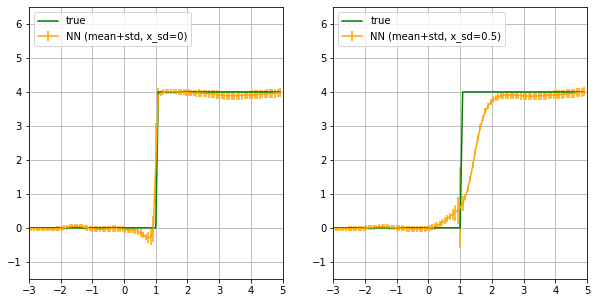

In [203]:
length = 100
start = -3
end = 5
waith = end - start
in_var1 = 0.
in_var2 = 0.25
val_x1 = torch.tensor([[i, in_var1] for i in np.arange(start,end,waith/length)])
val_x2 = torch.tensor([[i, in_var2] for i in np.arange(start,end,waith/length)])
val_y = (val_x1[:,0]>1)*4

pred_y1 = model_stochastic(val_x1).detach().cpu()
mu1 = pred_y1[:,0]
std1 = torch.sqrt(pred_y1[:,1] + torch.pow(model_error(val_x[:,0].view(-1,1)).detach().cpu(),2).view(-1))

pred_y2 = model_stochastic(val_x2).detach().cpu()
mu2 = pred_y2[:,0]
std2 = torch.sqrt(pred_y1[:,1] + torch.pow(model_error(val_x[:,0].view(-1,1)).detach().cpu(),2).view(-1))


fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1,2,1)
ax1.errorbar(val_x[:,0], mu1, std1, label="NN (mean+std, x_sd=0)",c="orange")
ax1.plot(val_x[:,0], val_y, label="true",c="g")
ax1.grid()
ax1.legend(loc='upper left')
plt.xlim(-3, 5)
plt.ylim(-1.5, 6.5)

ax2 = fig.add_subplot(1,2,2)
ax2.errorbar(val_x[:,0], mu2, std2, label="NN (mean+std, x_sd=0.5)",c="orange")
ax2.plot(val_x[:,0], val_y, label="true",c="g")
ax2.grid()
ax2.legend(loc='upper left')
plt.xlim(-3, 5)
plt.ylim(-1.5, 6.5)

fig.show()

Fig. 3. Learning a step function.

# Regressrion Linear Function with changing noize

In [206]:
class LinearDataset(data.Dataset):
    
    def __init__(self, upper=5, lower=-5, length=100, error_range1=1, error_range2=0.25, model_mean=None, seed=1234):
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        
        self.length = length
        noise1 = np.array([np.random.uniform(-error_range1,error_range1) for i in range(self.length)]).reshape(-1,1).astype(np.float32)
        noise2 = np.array([np.random.uniform(-error_range2,error_range2) for i in range(self.length)]).reshape(-1,1).astype(np.float32)
         
        self.input = np.array([np.random.uniform(lower,upper) for i in range(self.length)]).reshape(-1,1).astype(np.float32)
        self.output = (0.5 * self.input).astype(np.float32)
        self.output[np.abs(self.output)<1] += np.array([np.random.uniform(-error_range1,error_range1) for i in range(len(self.output[np.abs(self.output)<1]))]).astype(np.float32)
        self.output[np.abs(self.output)>=1] += np.array([np.random.uniform(-error_range2,error_range2) for i in range(len(self.output[np.abs(self.output)>=1]))]).astype(np.float32)
        if model_mean!=None:
            pred = model_mean(torch.tensor(self.input)).to("cpu")
            self.output = torch.abs(torch.tensor(self.output) - pred)

    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        x = self.input[index]
        y = self.output[index]
        
        return x, y

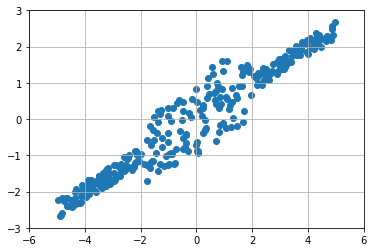

In [207]:
dataset = LinearDataset(length=300,seed=SEED)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=300,shuffle=True)
x, y = next(iter(dataloader))

plt.scatter(x, y)
plt.xlim(-6, 6)
plt.ylim(-3, 3)
plt.grid()
plt.show()

In [211]:
dataset = LinearDataset(error_range1=3, length=300,seed=SEED)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=64,shuffle=True)

model_mean_l = BasicRegressor()
model_mean_l = train_mean(model_mean_l, dataloader,30)

-------------
Epoch 1/30
-------------
-------------
epoch 0 || Loss:0.2484 
timer:  0.1042 sec.
-------------
Epoch 2/30
-------------
-------------
epoch 1 || Loss:0.1573 
timer:  0.0284 sec.
-------------
Epoch 3/30
-------------
-------------
epoch 2 || Loss:0.1538 
timer:  0.0316 sec.
-------------
Epoch 4/30
-------------
-------------
epoch 3 || Loss:0.1392 
timer:  0.0307 sec.
-------------
Epoch 5/30
-------------
-------------
epoch 4 || Loss:0.1403 
timer:  0.0523 sec.
-------------
Epoch 6/30
-------------
-------------
epoch 5 || Loss:0.1363 
timer:  0.0338 sec.
-------------
Epoch 7/30
-------------
-------------
epoch 6 || Loss:0.1358 
timer:  0.0267 sec.
-------------
Epoch 8/30
-------------
-------------
epoch 7 || Loss:0.1392 
timer:  0.0369 sec.
-------------
Epoch 9/30
-------------
-------------
epoch 8 || Loss:0.1342 
timer:  0.0353 sec.
-------------
Epoch 10/30
-------------
-------------
epoch 9 || Loss:0.1361 
timer:  0.0381 sec.
-------------
Epoch 11/30
---

In [217]:
dataset = LinearDataset(error_range1=3, length=300, model_mean=model_mean_l,seed=SEED)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=64,shuffle=True)

model_error_l = BasicRegressor()
model_error_l = train_error(model_error_l, dataloader,300)

-------------
Epoch 1/300
-------------
-------------
epoch 0 || Loss:0.0572 
timer:  0.0644 sec.
-------------
Epoch 2/300
-------------
-------------
epoch 1 || Loss:0.0218 
timer:  0.0519 sec.
-------------
Epoch 3/300
-------------
-------------
epoch 2 || Loss:0.0158 
timer:  0.0468 sec.
-------------
Epoch 4/300
-------------
-------------
epoch 3 || Loss:0.0154 
timer:  0.0494 sec.
-------------
Epoch 5/300
-------------
-------------
epoch 4 || Loss:0.0125 
timer:  0.0600 sec.
-------------
Epoch 6/300
-------------
-------------
epoch 5 || Loss:0.0134 
timer:  0.0503 sec.
-------------
Epoch 7/300
-------------
-------------
epoch 6 || Loss:0.0125 
timer:  0.0432 sec.
-------------
Epoch 8/300
-------------
-------------
epoch 7 || Loss:0.0116 
timer:  0.0483 sec.
-------------
Epoch 9/300
-------------
-------------
epoch 8 || Loss:0.0115 
timer:  0.0443 sec.
-------------
Epoch 10/300
-------------
-------------
epoch 9 || Loss:0.0107 
timer:  0.0721 sec.
-------------
Epoch

-------------
epoch 86 || Loss:0.0075 
timer:  0.0491 sec.
-------------
Epoch 88/300
-------------
-------------
epoch 87 || Loss:0.0078 
timer:  0.0602 sec.
-------------
Epoch 89/300
-------------
-------------
epoch 88 || Loss:0.0078 
timer:  0.0558 sec.
-------------
Epoch 90/300
-------------
-------------
epoch 89 || Loss:0.0073 
timer:  0.0519 sec.
-------------
Epoch 91/300
-------------
-------------
epoch 90 || Loss:0.0074 
timer:  0.0608 sec.
-------------
Epoch 92/300
-------------
-------------
epoch 91 || Loss:0.0075 
timer:  0.0763 sec.
-------------
Epoch 93/300
-------------
-------------
epoch 92 || Loss:0.0078 
timer:  0.0618 sec.
-------------
Epoch 94/300
-------------
-------------
epoch 93 || Loss:0.0076 
timer:  0.0768 sec.
-------------
Epoch 95/300
-------------
-------------
epoch 94 || Loss:0.0074 
timer:  0.0786 sec.
-------------
Epoch 96/300
-------------
-------------
epoch 95 || Loss:0.0077 
timer:  0.0638 sec.
-------------
Epoch 97/300
-------------


-------------
epoch 169 || Loss:0.0080 
timer:  0.0562 sec.
-------------
Epoch 171/300
-------------
-------------
epoch 170 || Loss:0.0084 
timer:  0.0434 sec.
-------------
Epoch 172/300
-------------
-------------
epoch 171 || Loss:0.0079 
timer:  0.0436 sec.
-------------
Epoch 173/300
-------------
-------------
epoch 172 || Loss:0.0080 
timer:  0.0534 sec.
-------------
Epoch 174/300
-------------
-------------
epoch 173 || Loss:0.0079 
timer:  0.0667 sec.
-------------
Epoch 175/300
-------------
-------------
epoch 174 || Loss:0.0074 
timer:  0.0695 sec.
-------------
Epoch 176/300
-------------
-------------
epoch 175 || Loss:0.0073 
timer:  0.0681 sec.
-------------
Epoch 177/300
-------------
-------------
epoch 176 || Loss:0.0073 
timer:  0.0593 sec.
-------------
Epoch 178/300
-------------
-------------
epoch 177 || Loss:0.0073 
timer:  0.0571 sec.
-------------
Epoch 179/300
-------------
-------------
epoch 178 || Loss:0.0075 
timer:  0.0596 sec.
-------------
Epoch 18

-------------
epoch 252 || Loss:0.0076 
timer:  0.0527 sec.
-------------
Epoch 254/300
-------------
-------------
epoch 253 || Loss:0.0074 
timer:  0.0595 sec.
-------------
Epoch 255/300
-------------
-------------
epoch 254 || Loss:0.0071 
timer:  0.0466 sec.
-------------
Epoch 256/300
-------------
-------------
epoch 255 || Loss:0.0070 
timer:  0.0729 sec.
-------------
Epoch 257/300
-------------
-------------
epoch 256 || Loss:0.0076 
timer:  0.0701 sec.
-------------
Epoch 258/300
-------------
-------------
epoch 257 || Loss:0.0072 
timer:  0.0590 sec.
-------------
Epoch 259/300
-------------
-------------
epoch 258 || Loss:0.0071 
timer:  0.0500 sec.
-------------
Epoch 260/300
-------------
-------------
epoch 259 || Loss:0.0070 
timer:  0.0463 sec.
-------------
Epoch 261/300
-------------
-------------
epoch 260 || Loss:0.0076 
timer:  0.0608 sec.
-------------
Epoch 262/300
-------------
-------------
epoch 261 || Loss:0.0072 
timer:  0.0733 sec.
-------------
Epoch 26

/home/yashima/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  del sys.path[0]


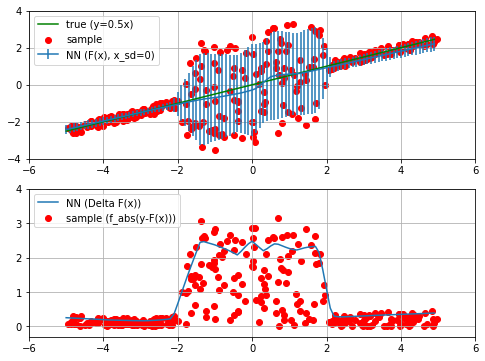

In [218]:
length = 100
start = -5
end = 5
waith = end - start
val_x = torch.tensor([[i] for i in np.arange(start,end,waith/length)])
val_y = 0.5*val_x
pred_y = model_mean_l(val_x).detach().cpu()
pred_std = model_error_l(val_x).detach().cpu()


fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(2,1,1)
ax.errorbar(val_x, pred_y, pred_std, label="NN (F(x), x_sd=0)")
ax.plot(val_x, val_y, label="true (y=0.5x)",c="g")

dataset = LinearDataset(error_range1=3, length=300,seed=SEED)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=300,shuffle=True)
x, y = next(iter(dataloader))
ax.scatter(x, y,c="r",label="sample")

ax.grid()
ax.legend(loc='upper left')
plt.xlim(-6, 6)
plt.ylim(-4, 4)



dataset = LinearDataset(error_range1=3, length=300, model_mean=model_mean_l,seed=SEED)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=300,shuffle=True)
dataloader = iter(dataloader)
x,y = next(dataloader)
y = y.detach().cpu()

ax = fig.add_subplot(2,1,2)
ax.scatter(x,y,c="r",label="sample (f_abs(y-F(x)))")
ax.plot(val_x,pred_std,label="NN (Delta F(x))")

ax.grid()
ax.legend(loc='upper left')
plt.xlim(-6, 6)
plt.ylim(-0.3, 4)


fig.show()

Fig. 4. Learning $y=0.5x$ with output noise depending on $x$.